# Case study of the U2 snRNA

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## 1. Data preparation

Here, we choose the U2 snRNA as an example RNA to show the characteristics of PARIS reads, and then use this RNA to explain how PARSE works. First, we load the reference sequence and the mapped PARIS reads of the U2 snRNA.

In [2]:
demo_rna_id = 'bpRNA_RFAM_999|RF00004_ABBA01028418.1_3128-3319|U2_spliceosomal_RNA|Rfam||0|192|1|published'

from PARSE.Info_RNA import *
from Bio import SeqIO

for ref_rna in SeqIO.parse('./data/Rfam_H.S._nonsim.fa', 'fasta'):
    if ref_rna.id == demo_rna_id:
        demo_rna = Info_RNA(ref_rna.id, ref_rna.seq)
        
location_marker = [0, 50, 100, 150, 192]
print('ID:', demo_rna.ident)
print('Sequence:', demo_rna.seq)

demo_rna.PARIS = Info_PARIS('./data/PARIS_reads/split/' + demo_rna.ident + '.bam')

ID: bpRNA_RFAM_999|RF00004_ABBA01028418.1_3128-3319|U2_spliceosomal_RNA|Rfam||0|192|1|published
Sequence: AUCUCUUCUCGUCCUUUUGGCUAAGAUCAAGUGUAGUAUCUGUUCUUAUCAGUUUAAUAUCUGAUACGUCCUCUAUCAGAGAACAAUUAUAUUAGAUAGAUUUUUGGAGCAGGGAGAUGAAAUAGGAGCUUGCUCUGUCCACUCCACGCGUCGACCUGGUAUUGCAGUACCUCCAGGAAUGGGGCUCCCUCU


The length of the U2 snRNA is 192 nt. After loading PARIS reads mapped to the U2 snRNA, here we use the following codes to show an example of incompatible and fuzzy PARIS reads on the tail of the U2 snRNA, focusing on three regions: A (115 nt ~ 125 nt), B (145 nt ~ 155 nt), and C (175 nt ~ 185 nt). 

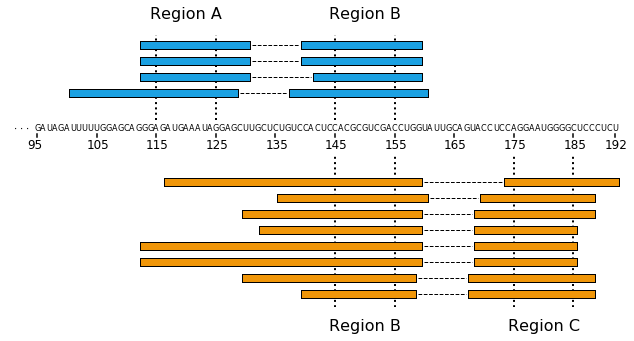

In [3]:
from PARSE.Utils import *

region_A, region_B, region_C = [115, 125], [145, 155], [175, 185]
blue_reads, orange_reads = [], []
for (ll, lr), (rl, rr) in demo_rna.PARIS.blocks:
    # Collect reads covering region A and B
    if ll <= region_A[0] and lr >= region_A[1] and rl <= region_B[0] and rr >= region_B[1]:
        blue_reads.append(((ll, lr), (rl, rr)))
    # Collect reads covering region B and C
    if ll <= region_B[0] and lr >= region_B[1] and rl <= region_C[0] and rr >= region_C[1]:
        orange_reads.append(((ll, lr), (rl, rr)))

fig = plt.figure(figsize=(11, 5))
ax = plt.subplot(111)

# Draw the bases from 95 to 192 of the U2 snRNA sequence
for i in range(91, 94):
    plt.text(i, 0, '$\cdot$')
for i in range(94, len(demo_rna.seq)):
    plt.text(i+0.5, 0, demo_rna.seq[i], fontsize = 8)
    
# Draw the coordinates of RNA locations
x_ticks = list(range(95, len(demo_rna.seq), 10))
x_ticks.append(len(demo_rna.seq))
for i in x_ticks:
    plt.plot([i, i], [-0.2, -0.4], 'k')
    plt.text(i-1.7, -1.1, i, fontsize = 12)

# Draw mark lines of regions
plt.text(np.mean(region_A), 7, 'Region A', horizontalalignment='center', fontsize = 16)
plt.text(np.mean(region_B), 7, 'Region B', horizontalalignment='center', fontsize = 16)
for loc in [*region_A, *region_B]:
    plt.plot([loc, loc], [0.7, 7], 'k:', linewidth = 2)
    
plt.text(np.mean(region_B), -12.5, 'Region B', horizontalalignment='center', fontsize = 16)
plt.text(np.mean(region_C), -12.5, 'Region C', horizontalalignment='center', fontsize = 16)   
for loc in [*region_B, *region_C]:
    plt.plot([loc, loc], [-13, -1.5], 'k:', linewidth = 2)

# Fix the size of figure
ax.set_xlim([90, len(demo_rna.seq)+1])
ax.set_ylim([-3-len(orange_reads), len(blue_reads)+2])


# A function for draw a read
def draw_reads(read, y, color):
    (ll,lr), (rl, rr) = read
    ax.plot([ll,lr], [y, y], c = 'k', linewidth = 9); ax.plot([ll,lr], [y, y], c = color, linewidth = 7)
    ax.plot([lr+1,rl-1], [y, y], c = 'k', linewidth = 1, linestyle = '--')
    ax.plot([rl,rr], [y, y], c = 'k', linewidth = 9); ax.plot([rl,rr], [y, y], c = color, linewidth = 7)

# Draw red reads
for i in range(len(blue_reads)):
    draw_reads(blue_reads[i], i+2.4, Utils.VBLUE)
    
# Draw orange reads
for i in range(len(orange_reads)):
    draw_reads(orange_reads[i], -i-3.2, Utils.VORANGE)
    
ax.set(frame_on=False)
ax.axis('off')
plt.show()

As shown in the figure above, we can see that the region B simultaneously interacts with region A supported by 4 blue reads and region C supported by 8 yellow reads, and the regions are too wide to exactly identify the paired bases.

## 2. Performing PARSE on the U2 snRNA

### 2.1. Scoring pairwise interactions

Using the given RNA sequence and PARIS reads, we execute PARSE step by step to demonstrate the main idea of PARSE. The first step of PARSE is to score the pairwise interactions by defining 'PARIS support' based on PARIS reads. This is implemented as the class `Scoring` in [PARSE/PARSE_core.py](PARSE/PARSE_core.py), and the usage is as follows.

In [4]:
from PARSE.PARSE_Core import *
from PARSE.Baseline_Methods import *

PARSE_scoring = Scoring(demo_rna)
PARSE_scoring.compute_PARIS_support()

=== Convert PARIS reads to PARIS support matrix ===
--- The standard deviation is 3.937
=== Finished! ===




Then we use the following codes to plot the heatmap of PARIS support.

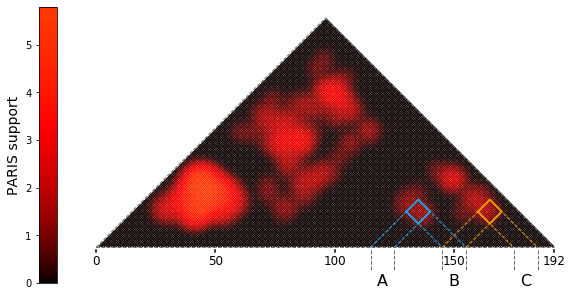

In [5]:
# Draw the heatmap of triangle matrix
fig, axs = plt.subplots(1, 1, figsize = (8, 4), constrained_layout=True)
ax = axs
Utils.plot_triangle_matrix(ax, PARSE_scoring.PARIS_support, Utils.black2red_cmap)

# Draw the color bar legend
PARIS_support_cmap_norm = mpl.colors.Normalize(0, np.max(PARSE_scoring.PARIS_support))
cbar1 = plt.colorbar(cm.ScalarMappable(PARIS_support_cmap_norm, Utils.black2red_cmap), 
                     aspect = 30, ax = axs, location = 'left')
cbar1.set_label(label = 'PARIS support', fontsize = 14)

# Draw location marker manually
ax.axes.get_xaxis().set_visible(False)
for loc in location_marker:
    ax.plot([loc, loc], [-1, -2], 'k')
    ax.text(loc, -7, loc, horizontalalignment='center', fontsize = 12)

# Draw regions
plt.text(np.mean(region_A), -16, 'A', horizontalalignment='center', fontsize = 16)
plt.text(np.mean(region_B), -16, 'B', horizontalalignment='center', fontsize = 16)
plt.text(np.mean(region_C), -16, 'C', horizontalalignment='center', fontsize = 16)
for pos in [*region_A, *region_B, *region_C]:
    plt.plot([pos, pos], [-1, -10], 'k--', linewidth = 1, color = Utils.VLGRAY)

# A function for drawing interacted regions
def draw_interacting_region(left_region, right_region, color):
    ll, lr = left_region; rl, rr = right_region
    plt.plot([ll, (ll+rl)/2, rl], [0, (rl-ll)/2, 0], color = color, linestyle = '--', linewidth = 1)
    plt.plot([lr, (lr+rr)/2, rr], [0, (rr-lr)/2, 0], color = color, linestyle = '--', linewidth = 1)
    plt.plot([(ll+rl)/2, (ll+rr)/2, (lr+rr)/2, (lr+rl)/2, (ll+rl)/2], 
             [(rl-ll)/2, (rr-ll)/2, (rr-lr)/2, (rl-lr)/2, (rl-ll)/2], color = color, linewidth = 2)
    
# Draw A-B region covered by blue reads
draw_interacting_region(region_A, region_B, Utils.VBLUE)
draw_interacting_region(region_B, region_C, Utils.VORANGE)

plt.show()

According to the heatmap of PARIS support shown above, we can note that, except for the incompatibility of the regions A, B, and C, the entire RNA is full of incompatible reads.

### 2.2. Generating candidate secondary structures

The second step of PARSE is to generate a set of candidate RNA secondary structures at locally minimum free energy containing the stems with PARIS support higher than a threshold. The implementation of the *generating* step includes many details, and the codes are packaged as the class `Generating` in [PARSE/PARSE_core.py]([`PARSE/PARSE_core.py`]). 

In [6]:
PARSE_generating = Generating(demo_rna, PARSE_scoring.PARIS_support)
PARSE_generating.generate(100, 0.75, [4, 5, 6, 7])

=== Generate candidate structures ===
+++ 100 structures expected
+++ Stems with PARIS support higher than 0.750 of all PARIS support are collected
+++ The range of length k for stems is  [4, 5, 6, 7]
--- The 0.750 fraction of PARIS support is 1.028
--- 438 4-mers can perfectly match (113 have high PARIS supports)
--- 170 5-mers can perfectly match (41 have high PARIS supports)
--- 76 6-mers can perfectly match (18 have high PARIS supports)
--- 34 7-mers can perfectly match (8 have high PARIS supports)
--- 180 stems are collected with high PARIS supports

--- 76 stems are retained after eliminating redundant stems
--- 2926 combinations of stems need to check if is compatible
--- 1142 compatible stems are reserved as hard constraints

--- Perform the constrained RNA folding algorithm
--- 114 structures completed ...
--- 228 structures completed ...
--- 342 structures completed ...
--- 456 structures completed ...
--- 570 structures completed ...
--- 684 structures completed ...
--- 798 

The *generating* step generates 100 candidate structures. We draw these structures in rainbow diagrams using [VARNA](http://varna.lri.fr/), and the output figures are in the folder [output/tmp/U2snRNP_candidate_structures/](output/tmp/U2snRNP_candidate_structures/).

In [7]:
plotter = Structure_Plotter(demo_rna.seq, PARSE_scoring.PARIS_support)
for i in range(len(PARSE_generating.candidate_structures)):
    if (i+1) % (len(PARSE_generating.candidate_structures) // 10) == 0:
        print('--- %d structures plotted ...' % (i+1))
    structure = PARSE_generating.candidate_structures[i]
    plotter.plot(structure, './output/tmp/U2snRNP_candidate_structures/%d.png' % i, 1)

--- 10 structures plotted ...
--- 20 structures plotted ...
--- 30 structures plotted ...
--- 40 structures plotted ...
--- 50 structures plotted ...
--- 60 structures plotted ...
--- 70 structures plotted ...
--- 80 structures plotted ...
--- 90 structures plotted ...
--- 100 structures plotted ...


### 2.3. Picking the optimal ensemble

The final step of PARSE is to infer an RNA secondary structure ensemble from the generated candidate structures to best interpret the PARIS data. The *picking* step is programmed as the class `Picking` in [PARSE/PARSE_core.py]([`PARSE/PARSE_core.py`]). Here, we pick two representative secondary structures as the final predicted ensemble of the U2 snRNA.

In [8]:
PARSE_picking = Picking(demo_rna, PARSE_scoring.PARIS_support, PARSE_generating.candidate_structures)
PARSE_picking.pick(2)

=== Pick the optimal ensemble with 2 structures ===
--- The lambda for the exponential distribution is 22.593
--- Eliminate redundant structures using LASSO regression
--- Try gamma = 1.00e+00, and get 0 non-zero coefficients
--- Try gamma = 5.00e-01, and get 0 non-zero coefficients
--- Try gamma = 2.50e-01, and get 0 non-zero coefficients
--- Try gamma = 1.25e-01, and get 0 non-zero coefficients
--- Try gamma = 6.25e-02, and get 0 non-zero coefficients
--- Try gamma = 3.12e-02, and get 0 non-zero coefficients
--- Try gamma = 1.56e-02, and get 0 non-zero coefficients
--- Try gamma = 7.81e-03, and get 0 non-zero coefficients
--- Try gamma = 3.91e-03, and get 0 non-zero coefficients
--- Try gamma = 1.95e-03, and get 2 non-zero coefficients
--- Try gamma = 9.77e-04, and get 8 non-zero coefficients
--- 8 non-zero coefficients are retained (end up with gamma = 9.77e-04)
--- 28 candidate ensembles are generated
=== Finished ===




The representative structures with corresponding proportions are shown using the following codes. In addition, we write codes to check which two structures are picked from the candidate structures.

In [9]:
print('=== The predicted ensemble of PARSE-2 of the U2 snRNA is')
PARSE_picking.ensemble.show()
print()

for i in range(len(PARSE_picking.ensemble.structures)):
    structure = PARSE_picking.ensemble.structures[i]
    for j in range(len(PARSE_generating.candidate_structures)):
        if structure == PARSE_generating.candidate_structures[j]:
            print('The representative structure %d is the %dth candidate structure' % (i+1, j))

=== The predicted ensemble of PARSE-2 of the U2 snRNA is
+++ Structure 1: 0.606533
.....(((((........(((....((((.((((.....(((.......)))....)))).))))..)))........)))))......................((((((((...............))))))))((((........(((...(((((.............))))).))))))).......
+++ Structure 2: 0.393467
.....(((((........(((....((((.((((.....(((.......)))....)))).))))..)))........)))))................((((((((((((((..((((.....((((...((...))...))))...))))..))))((((....))))))))))))))((((...)))).

The representative structure 1 is the 5th candidate structure
The representative structure 2 is the 64th candidate structure


We use [VARNA](http://varna.lri.fr/) to draw the rainbow diagrams of these two representative structures in the predicted ensemble. High-resolution figures can be found in the folder [output/RF00004_ABBA01028418.1_3128-3319/](output/RF00004_ABBA01028418.1_3128-3319/).

--- Plotting structure 1 (0.607) ... 
--- Plotting structure 2 (0.393) ... 


--- Displaying the rainbow diagrams of the representative structures

./output/RF00004_ABBA01028418.1_3128-3319/Structure1_0.607.png


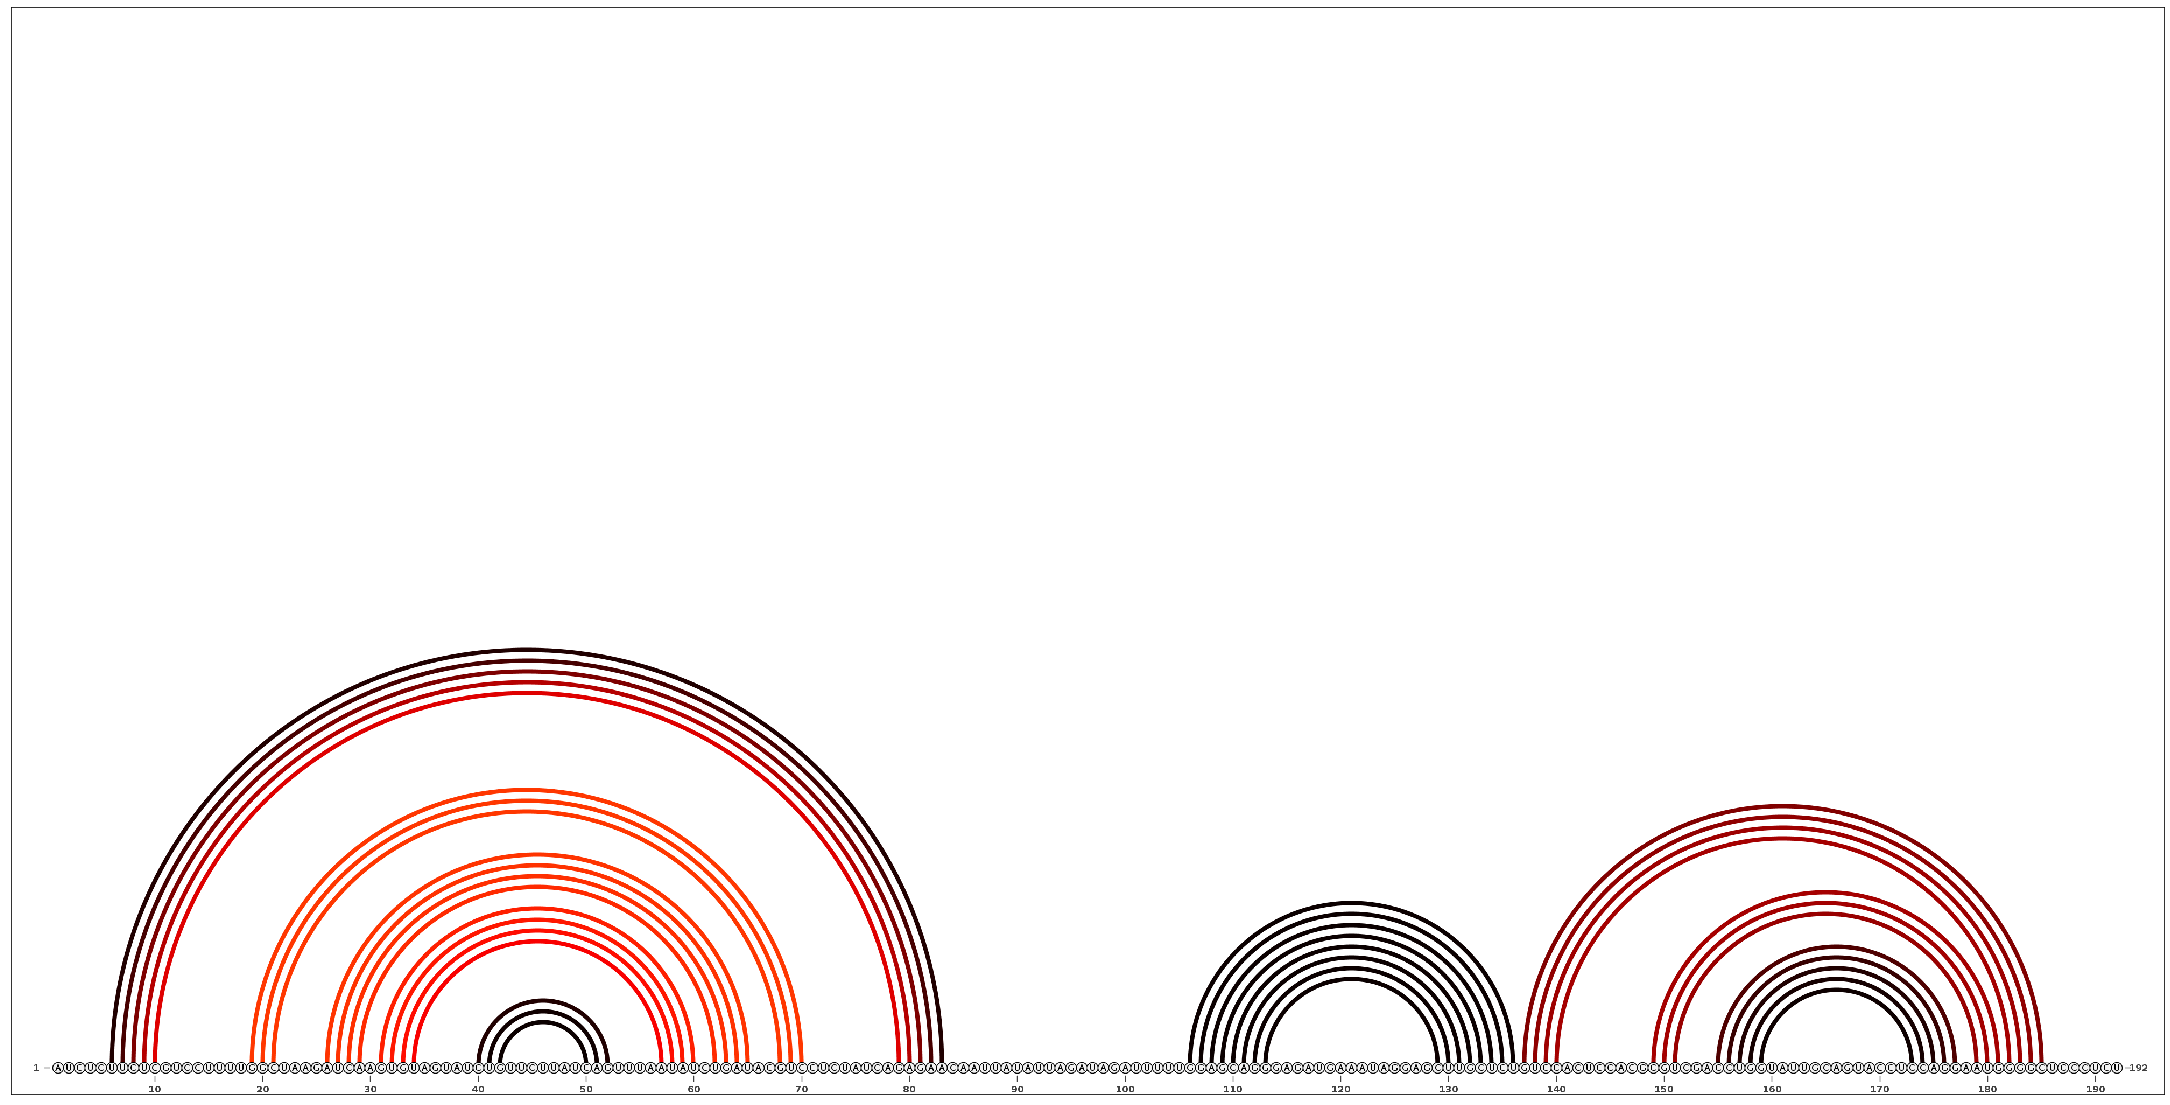


./output/RF00004_ABBA01028418.1_3128-3319/Structure2_0.393.png


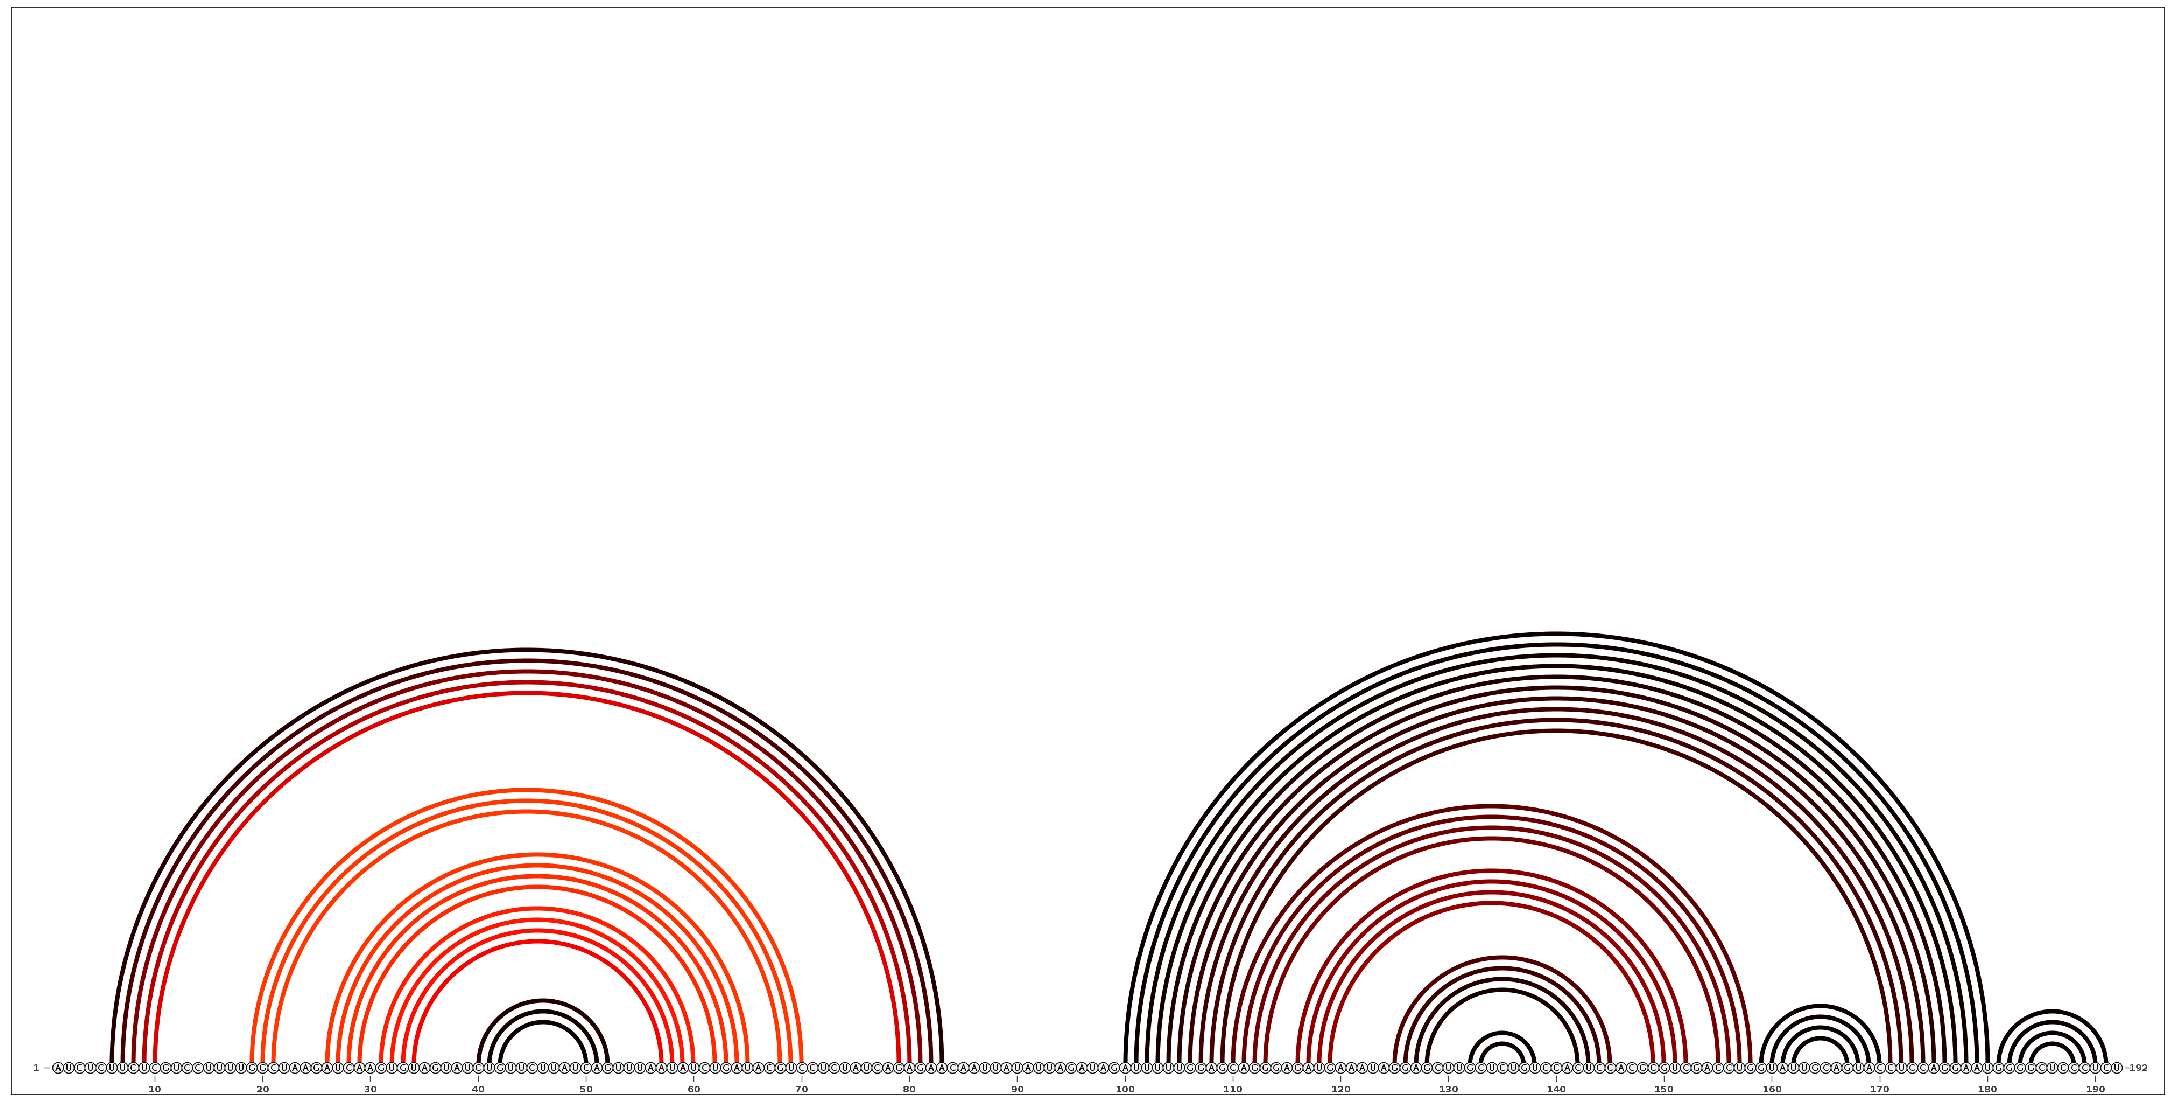

In [10]:
import os

output_dir = './output/' + demo_rna.ident.split('|')[1]
# Create the output folder
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
# Clean existed figures
for root, dirs, files in os.walk(output_dir):
    for file in files:
        os.remove(os.path.join(root, file))
        
rainbow_plot_files = PARSE_picking.ensemble.plot(PARSE_scoring.PARIS_support, output_dir)

print('\n\n--- Displaying the rainbow diagrams of the representative structures')

from PIL import Image
import matplotlib.pyplot as plt
for figure_path in rainbow_plot_files:
    print('\n' + figure_path)
    img = Image.open(figure_path)
    fig = plt.figure(figsize = (40, 20))
    plt.xticks([]); plt.yticks([])
    plt.imshow(img)
    plt.show()

## 3. Evaluation of PARSE on the U2 snRNA

### 3.1. The distribution of the predicted secondary structures

The goal of PARSE is to uncover secondary structures with low free energy supported by PARIS data, and identify the optimal ensemble from these structures. To analyse how PARSE works, we used the *generating* step of PARSE to generate 100 candidate structures of the U2 snRNA, and compare them with another 100 secondary structures generated by the non-redundant sampling algorithm (denote as NRDS). NRDS is the state-of-the-art method for exploring representative structures of the RNA folding landscape, considering only free energy. We also included the minimum free energy structure. 

In [11]:
from PARSE.Baseline_Methods import *

mfe = MFE(demo_rna)
mfe.predict()

nrds = Nonredundant_Sampling(demo_rna)
nrds.generate(100)

structures = {'NRDS': nrds.ensemble.structures, 'MFE': mfe.ensemble.structures,
              'PARSE': PARSE_generating.candidate_structures, 'PARSE-2': PARSE_picking.ensemble.structures}

Next, we calculated the base pair distance between each pair of these 201 RNA secondary structures, and then performed multidimensional scaling based on the distance matrix to visualize the relationship between the structures by embedding them into a two-dimensional plane. Finally, we split the plane using the Voronoi diagram so that each dot representing the secondary structure occupies an area with a different color, where blue represents free energy and green represents PARIS support.

--- Computing the base-pairing distance matrix
--- Base pair distance matrix: 
 [[  0  81  79 ... 105  51  95]
 [ 81   0  64 ...  98  76  88]
 [ 79  64   0 ...  98  74  92]
 ...
 [105  98  98 ...   0 100  64]
 [ 51  76  74 ... 100   0  52]
 [ 95  88  92 ...  64  52   0]]
--- Embedding to 2D using multidimensional embedding (MDS)
--- Partition using Voronoi diagram and color by free energy


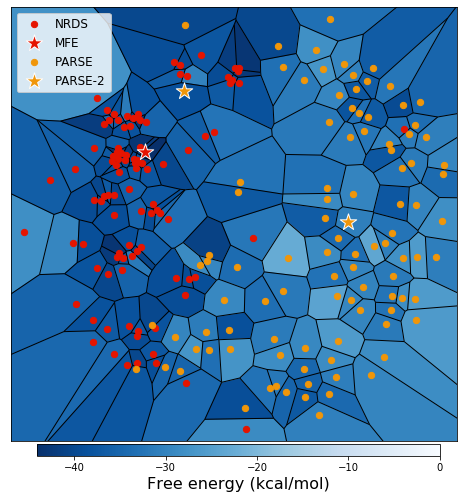

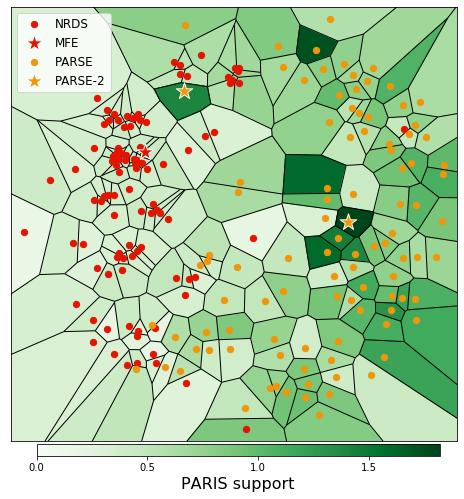

In [12]:
from PARSE.Utils import *

art_style = {}
art_style['NRDS'] = {'color': Utils.VRED, 'marker': 'o', 'scale': 2, 'edgecolor': None, 'zorder':1}
art_style['PARSE'] = {'color': Utils.VORANGE, 'marker': 'o', 'scale': 2, 'edgecolor': None, 'zorder':1}
art_style['MFE'] = {'color': Utils.VRED, 'marker': '*', 'scale': 15, 'edgecolor': 'w', 'zorder':3}
art_style['PARSE-2'] = {'color': Utils.VORANGE, 'marker': '*', 'scale': 15, 'edgecolor': 'w', 'zorder':3}

Utils.plot_structure_landscape(demo_rna.seq, structures, PARSE_scoring.PARIS_support, art_style)

### 3.3. Evaluation by evolutionary conservation

To validate the PARSE-predicted ensemble of the U2 snRNA by evolutionary conservation, we first retrieve the multiple sequence alignment of homologous sequences in the [U2 snRNA family](https://rfam.org/family/RF00004) and compute the normalized mutual information between each pair of by R-scape using the script file [data/Rfam_MSA/run_R-scape.py](data/Rfam_MSA/run_R-scape.py).

In [13]:
demo_rna.coevolution = Info_Coevolution(demo_rna, './data/Rfam_MSA/sto_files', './data/Rfam_MSA/cov_files')

Here, we plot the normalized mutual information as the following heatmap.

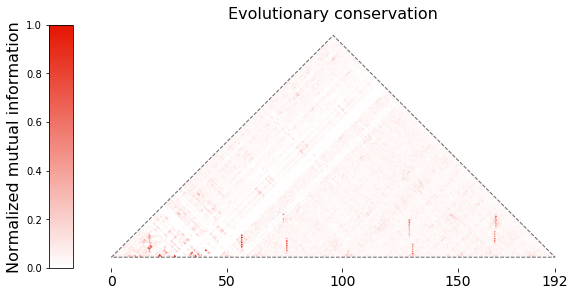

In [14]:
from PARSE.Utils import *
demo_rna.coevolution.plot_covariation_matrix(location_marker)

Then, we run PARSE to predict the structure ensemble with 1, 2, and 3 representative secondary structures (denoted as PARSE-1, PARSE-2 and PARSE-3, respectively), and also predicted the minimum free energy structure (denoted as MFE).

In [15]:
mfe = MFE(demo_rna)
mfe.predict()
MFE_ensemble = mfe.ensemble
PARSE_picking.ostream = open('/dev/null', 'w')
PARSE_picking.pick(1)
PARSE_1_ensemble = PARSE_picking.ensemble
PARSE_picking.pick(2)
PARSE_2_ensemble = PARSE_picking.ensemble
PARSE_picking.pick(3)
PARSE_3_ensemble = PARSE_picking.ensemble

We calculate the KL distance between the base-pairing probability matrix of the predicted ensemble and the normalized mutual information matrix as the benchmarking metric.


In [16]:
from tabulate import tabulate

KL_MFE = demo_rna.coevolution.evaluate_KL_divergence(MFE_ensemble)
KL_PARSE_1 = demo_rna.coevolution.evaluate_KL_divergence(PARSE_1_ensemble)
KL_PARSE_2 = demo_rna.coevolution.evaluate_KL_divergence(PARSE_2_ensemble)
KL_PARSE_3 = demo_rna.coevolution.evaluate_KL_divergence(PARSE_3_ensemble)

print(tabulate([[demo_rna.ident.split('|')[1], KL_MFE, 
                 Utils.emphasize(KL_PARSE_1, KL_MFE, '<='),
                 Utils.emphasize(KL_PARSE_2, KL_MFE, '<='),
                 Utils.emphasize(KL_PARSE_3, KL_MFE, '<=')]], 
               headers = ['Rfam ID', 'MFE', 'PARSE-1', 'PARSE-2', 'PARSE-3']))

Rfam ID                               MFE    PARSE-1    PARSE-2    PARSE-3
--------------------------------  -------  ---------  ---------  ---------
RF00004_ABBA01028418.1_3128-3319  147.665       98.1         98         93


To make the benchmarking more intuitive, we plot the base-pairing probability matrices from ensembles predicted by MFE, PARSE-1, PARSE-2, and PARSE-3 as follows.

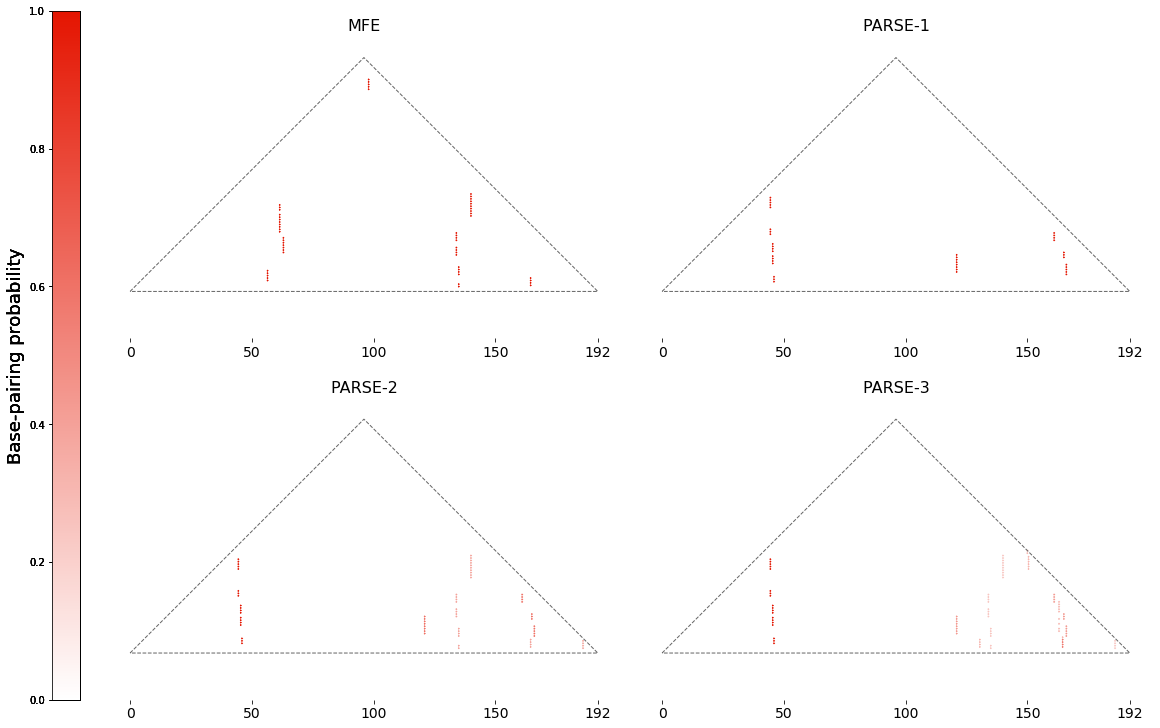

In [17]:
ensembles = {'MFE': MFE_ensemble, 'PARSE-1': PARSE_1_ensemble, 
             'PARSE-2': PARSE_2_ensemble, 'PARSE-3': PARSE_3_ensemble}

fig, axs = plt.subplots(2, 2, figsize = (16, 10), constrained_layout=True)
locs = [(0,0), (0,1), (1,0), (1,1)]
i_loc = 0
for label in ensembles:
    ax = axs[locs[i_loc]]
    Utils.plot_triangle_matrix(ax, ensembles[label].get_bpp_per_pair(), Utils.white2red_cmap)
    ax.set_title(label, y = 0.92, fontsize = 16)
    ax.set_xticks(location_marker)
    ax.set_xticklabels(location_marker, y = 0, fontsize = 14)
    i_loc += 1
    cbar1 = fig.colorbar(cm.ScalarMappable(mpl.colors.Normalize(0, 1),  Utils.white2red_cmap), 
                         aspect = 40, ax = axs, location = 'left')
    cbar1.set_label(label = 'Base-pairing probability', fontsize = 18)
plt.show()

Focusing on the three matrices from PARSE, we can note that all structures in different ensembles are fully conserved on the heading half of the U2 snRNA as a long stem component. The alternative structures generated by PARSE-2 and PARSE-3 are all located on the tailing half of the RNA. The ability to accurately predict consecutive conserved base pairs located at the tailing 50 nt of the U2 snRNA contributes substantially to the increased performance of PARSE.